In [67]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
import torch.optim as optim
import os
import random
import cv2
import numpy as np

In [68]:
class_label_real = 0
class_label_attack = 1

In [69]:
data_path_train_real = '/home/taha/FASdatasets/Sohail/Replay-Mobile/train/real'
data_path_train_attack = '/home/taha/FASdatasets/Sohail/Replay-Mobile/train/attack'

data_path_devel_real = '/home/taha/FASdatasets/Sohail/Replay-Mobile/devel/real'
data_path_devel_attack = '/home/taha/FASdatasets/Sohail/Replay-Mobile/devel/attack'

data_path_test_real = '/home/taha/FASdatasets/Sohail/Replay-Mobile/test/real'
data_path_test_attack = '/home/taha/FASdatasets/Sohail/Replay-Mobile/test/attack'

In [70]:
def load_samples(path, class_label, transform): #Select N frames returned from read_all_frames and assign labels to all samples of same class
        frames = read_all_frames(path)
        total_frames = list(range(0, frames.shape[0], 1))
        selected_samples = random.sample(total_frames, 1)
        samples =[]
        # Assign the same class label to all samples
        label = class_label
        samples =(transform(frames[selected_samples].squeeze()), label)     
        return samples

def read_all_frames(video_path): # _read_all_frames reads all frames from a  particular video, resizes them to 64x64, and converts them to PyTorch tensors.
    frame_list = []
    video = cv2.VideoCapture(video_path)
    success = True
    while success:
        success, frame = video.read()
        if success:
            frame = cv2.resize(frame, (64, 64), interpolation=cv2.INTER_AREA)
            frame_list.append(frame)
    frame_list = np.array(frame_list)
    return frame_list

class VideoDataset(Dataset):
    def __init__(self, data_path, class_label):
        self.data_path = data_path #path for directory containing video files
        self.video_files = [file for file in os.listdir(data_path) if file.endswith('.mov')] #list of video files in the specified directory
        self.class_label = class_label #manually assign class_label for your desired class while loading
        self.data_length = len(self.video_files) #*num_frames
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self): #Returns the total number of samples in the dataset
        return self.data_length
        # return len(self.samples)

    def __getitem__(self, idx):
        file = self.video_files[idx]
        path = os.path.join(self.data_path, file)
        frames= load_samples(path, self.class_label, self.transform)

        return frames

In [71]:
# Create datasets and data loaders
train_dataset_real = VideoDataset(data_path_train_real, class_label_real)
train_dataset_attack = VideoDataset(data_path_train_attack, class_label_attack)

val_dataset_real = VideoDataset(data_path_devel_real, class_label_real)
val_dataset_attack = VideoDataset(data_path_devel_attack, class_label_attack)

test_dataset_real = VideoDataset(data_path_test_real, class_label_real)
test_dataset_attack = VideoDataset(data_path_test_attack, class_label_attack)

In [72]:
train_loader_real = DataLoader(train_dataset_real, batch_size=1, shuffle=True)
train_loader_attack = DataLoader(train_dataset_attack, batch_size=1, shuffle=True)

val_loader_real = DataLoader(val_dataset_real, batch_size=1, shuffle=False)
val_loader_attack = DataLoader(val_dataset_attack, batch_size=1, shuffle=False)

test_loader_real = DataLoader(test_dataset_real, batch_size=1, shuffle=False)
test_loader_attack = DataLoader(test_dataset_attack, batch_size=1, shuffle=False)

In [73]:
# Concatenate datasets
concatenated_train_dataset = ConcatDataset([train_dataset_real, train_dataset_attack])
concatenated_val_dataset = ConcatDataset([val_dataset_real, val_dataset_attack])
concatenated_test_dataset = ConcatDataset([test_dataset_real, test_dataset_attack])


# Create a DataLoader for the concatenated dataset
concatenated_train_loader = DataLoader(concatenated_train_dataset, batch_size=64, shuffle=True, pin_memory=False, num_workers=8)
concatenated_val_loader = DataLoader(concatenated_val_dataset, batch_size=64, shuffle=False, pin_memory=False, num_workers=8)
concatenated_test_loader = DataLoader(concatenated_test_dataset, batch_size=64, shuffle=False, pin_memory=False, num_workers=8)

Replay Mobile DataSet:

Training -> 312 (Real 120, Attack 192) ->  312/1030 * 100 = 30.29%

Validation -> 416 (Real 160, Attack 256) -> 416/1030 * 100 = 40.38%

Testing -> 302 (Real 110, Attack 192) -> 302/1030 * 100 = 29.32%

Total = 1030

In [74]:
# Print dataset sizes
print(f"Training set size: {len(concatenated_train_dataset)}")
print(f"Validation set size: {len(concatenated_val_dataset)}")
print(f"Test set size: {len(concatenated_test_dataset)}")

Training set size: 312
Validation set size: 416
Test set size: 302


In [30]:
for train_frames, train_labels in concatenated_train_loader: 
    print(train_frames.shape, train_labels.shape)

print(len(concatenated_train_loader))

torch.Size([64, 3, 64, 64]) torch.Size([64])
torch.Size([64, 3, 64, 64]) torch.Size([64])
torch.Size([64, 3, 64, 64]) torch.Size([64])
torch.Size([64, 3, 64, 64]) torch.Size([64])
torch.Size([56, 3, 64, 64]) torch.Size([56])
5


https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

In [75]:
class Custom_CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(32768, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(in_features=512, out_features=2)
 
    def forward(self, x):
        # input 3x64x64, output 32x64x64
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x64x64, output 32x64x64
        x = self.act2(self.conv2(x))
        # input 32x64x64, output 32x32x32
        x = self.pool2(x)
        # input 32x32x32, output 32768 (32*32*32 = 32768)
        x = self.flat(x)
        # input 32768, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 2
        x = self.fc4(x)
        return x

In [76]:
model = Custom_CNN_Model()
print(model)

Custom_CNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=32768, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=2, bias=True)
)


In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [78]:
#Training loop
epochs = 50
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


# Set up early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
best_loss = float('inf') #set to positive infinity to ensure that the first validation loss encountered will always be considered an improvement
counter = 0  # Counter to keep track of consecutive epochs with no improvement

#Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    train_correct_predictions = 0
    total_train_samples = 0

    for iteration_no, (train_images, train_labels) in tqdm(enumerate(concatenated_train_loader,0), unit="batch", total=len(concatenated_train_loader)):
        # train_images, train_labels = train_data[0][0], train_data[0][1]
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_images)
        # Find the Loss
        train_loss = criterion(train_outputs, train_labels)
        # Calculate gradients
        train_loss.backward()
        # Update Weights
        optimizer.step()

        # accumulate the training loss
        running_loss += train_loss.item()

        # calculate training accuracy
        _, train_predicted = torch.max(train_outputs, 1) # _ contain max value, train_predicted contain the indices where maximum value occured
        train_correct_predictions += (train_predicted == train_labels).sum().item() 
        total_train_samples += train_labels.size(0)
            
    train_total_loss = running_loss / len(concatenated_train_loader)
    train_accuracy = train_correct_predictions / total_train_samples * 100
    train_losses.append(train_total_loss)
    train_accuracies.append(train_accuracy)

    
    #Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_prediction = 0
    total_val_samples = 0
    val_total_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in concatenated_val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_op = model(val_images)
            val_loss = criterion(val_op, val_labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_op, 1)
            val_correct_prediction += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
        
        val_total_loss = val_running_loss / len(concatenated_val_loader)
        val_accuracy = val_correct_prediction / total_val_samples * 100
        val_losses.append(val_total_loss)
        val_accuracies.append(val_accuracy)

    # Check if validation loss has improved
    if val_total_loss < best_loss:
        best_loss = val_total_loss
        counter = 0
        # Save the model if needed
        # torch.save(model.state_dict(), 'best_model.pth')

    else:
        counter += 1

        # Check if training should be stopped
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break


    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_total_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_total_loss: .4f}, Best Loss: {best_loss: .4f}, Validation Accuracy: {val_accuracy:.2f}%')

100%|██████████| 5/5 [01:55<00:00, 23.09s/batch] 


Epoch 1/50, Training Loss: 1.5368, Training Accuracy: 58.97%, Validation Loss:  0.4710, Best Loss:  0.4710, Validation Accuracy: 75.96%


100%|██████████| 5/5 [01:56<00:00, 23.30s/batch] 


Epoch 2/50, Training Loss: 0.5656, Training Accuracy: 75.64%, Validation Loss:  0.6360, Best Loss:  0.4710, Validation Accuracy: 75.72%


100%|██████████| 5/5 [01:57<00:00, 23.59s/batch] 


Epoch 3/50, Training Loss: 0.4422, Training Accuracy: 82.37%, Validation Loss:  0.5198, Best Loss:  0.4710, Validation Accuracy: 81.25%


100%|██████████| 5/5 [01:59<00:00, 23.80s/batch] 


Epoch 4/50, Training Loss: 0.4096, Training Accuracy: 85.26%, Validation Loss:  0.4573, Best Loss:  0.4573, Validation Accuracy: 86.06%


100%|██████████| 5/5 [02:02<00:00, 24.59s/batch] 


Epoch 5/50, Training Loss: 0.3324, Training Accuracy: 87.82%, Validation Loss:  0.4754, Best Loss:  0.4573, Validation Accuracy: 84.13%


100%|██████████| 5/5 [02:00<00:00, 24.19s/batch] 


Epoch 6/50, Training Loss: 0.2838, Training Accuracy: 87.82%, Validation Loss:  0.2949, Best Loss:  0.2949, Validation Accuracy: 89.90%


100%|██████████| 5/5 [01:56<00:00, 23.25s/batch] 


Epoch 7/50, Training Loss: 0.2323, Training Accuracy: 88.14%, Validation Loss:  0.3656, Best Loss:  0.2949, Validation Accuracy: 85.10%


100%|██████████| 5/5 [01:56<00:00, 23.37s/batch] 


Epoch 8/50, Training Loss: 0.1983, Training Accuracy: 91.99%, Validation Loss:  0.1899, Best Loss:  0.1899, Validation Accuracy: 91.35%


100%|██████████| 5/5 [01:56<00:00, 23.34s/batch] 


Epoch 9/50, Training Loss: 0.1498, Training Accuracy: 93.59%, Validation Loss:  0.2263, Best Loss:  0.1899, Validation Accuracy: 93.03%


100%|██████████| 5/5 [01:55<00:00, 23.12s/batch] 


Epoch 10/50, Training Loss: 0.1635, Training Accuracy: 91.67%, Validation Loss:  0.1927, Best Loss:  0.1899, Validation Accuracy: 93.75%


100%|██████████| 5/5 [02:00<00:00, 24.07s/batch] 


Epoch 11/50, Training Loss: 0.1005, Training Accuracy: 97.44%, Validation Loss:  0.1214, Best Loss:  0.1214, Validation Accuracy: 96.88%


100%|██████████| 5/5 [02:01<00:00, 24.21s/batch] 


Epoch 12/50, Training Loss: 0.0785, Training Accuracy: 97.44%, Validation Loss:  0.1227, Best Loss:  0.1214, Validation Accuracy: 96.63%


100%|██████████| 5/5 [01:54<00:00, 22.87s/batch] 


Epoch 13/50, Training Loss: 0.0626, Training Accuracy: 97.76%, Validation Loss:  0.1456, Best Loss:  0.1214, Validation Accuracy: 94.71%


100%|██████████| 5/5 [01:59<00:00, 23.82s/batch] 


Epoch 14/50, Training Loss: 0.0546, Training Accuracy: 97.12%, Validation Loss:  0.0713, Best Loss:  0.0713, Validation Accuracy: 97.84%


100%|██████████| 5/5 [01:57<00:00, 23.53s/batch] 


Epoch 15/50, Training Loss: 0.0401, Training Accuracy: 98.08%, Validation Loss:  0.0822, Best Loss:  0.0713, Validation Accuracy: 97.12%


100%|██████████| 5/5 [01:58<00:00, 23.71s/batch] 


Epoch 16/50, Training Loss: 0.0566, Training Accuracy: 98.08%, Validation Loss:  0.1018, Best Loss:  0.0713, Validation Accuracy: 95.67%


100%|██████████| 5/5 [01:59<00:00, 23.90s/batch] 


Epoch 17/50, Training Loss: 0.0348, Training Accuracy: 99.36%, Validation Loss:  0.0542, Best Loss:  0.0542, Validation Accuracy: 98.32%


100%|██████████| 5/5 [02:00<00:00, 24.10s/batch] 


Epoch 18/50, Training Loss: 0.0340, Training Accuracy: 98.72%, Validation Loss:  0.0660, Best Loss:  0.0542, Validation Accuracy: 98.32%


100%|██████████| 5/5 [02:01<00:00, 24.21s/batch] 


Epoch 19/50, Training Loss: 0.0205, Training Accuracy: 99.36%, Validation Loss:  0.0513, Best Loss:  0.0513, Validation Accuracy: 97.60%


100%|██████████| 5/5 [01:59<00:00, 23.88s/batch] 


Epoch 20/50, Training Loss: 0.0275, Training Accuracy: 98.72%, Validation Loss:  0.0484, Best Loss:  0.0484, Validation Accuracy: 99.28%


100%|██████████| 5/5 [01:58<00:00, 23.71s/batch] 


Epoch 21/50, Training Loss: 0.0111, Training Accuracy: 100.00%, Validation Loss:  0.0355, Best Loss:  0.0355, Validation Accuracy: 98.80%


100%|██████████| 5/5 [02:00<00:00, 24.16s/batch] 


Epoch 22/50, Training Loss: 0.0111, Training Accuracy: 100.00%, Validation Loss:  0.0448, Best Loss:  0.0355, Validation Accuracy: 98.08%


100%|██████████| 5/5 [02:01<00:00, 24.22s/batch] 


Epoch 23/50, Training Loss: 0.0144, Training Accuracy: 99.36%, Validation Loss:  0.0395, Best Loss:  0.0355, Validation Accuracy: 98.80%


100%|██████████| 5/5 [01:59<00:00, 23.86s/batch] 


Epoch 24/50, Training Loss: 0.0088, Training Accuracy: 100.00%, Validation Loss:  0.0475, Best Loss:  0.0355, Validation Accuracy: 97.84%


100%|██████████| 5/5 [01:58<00:00, 23.61s/batch] 


Epoch 25/50, Training Loss: 0.0174, Training Accuracy: 99.04%, Validation Loss:  0.0439, Best Loss:  0.0355, Validation Accuracy: 98.56%


100%|██████████| 5/5 [01:57<00:00, 23.40s/batch] 


Early stopping at epoch 25


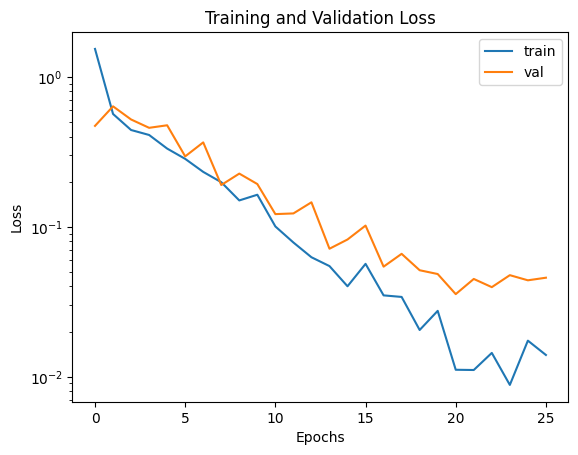

In [81]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
# plt.grid(True)
plt.legend()
plt.show()

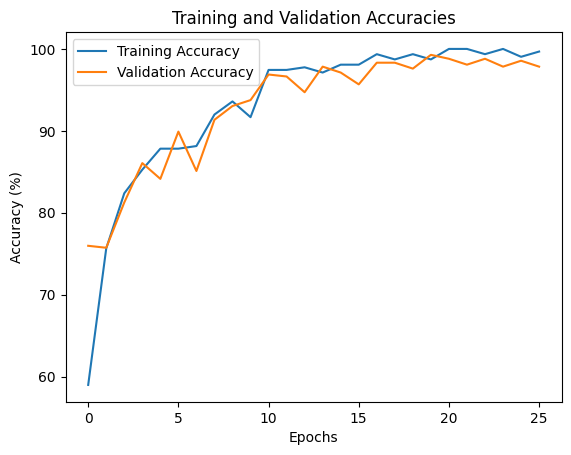

In [80]:
plt.figure()
plt.title("Training and Validation Accuracies")
plt.plot(train_accuracies,label="Training Accuracy")
plt.plot(val_accuracies,label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [82]:
# Evaluate on the test set
test_correct = 0
test_total = 0

model.eval()
with torch.no_grad():
    
    test_cat_labels = torch.empty(0, dtype=torch.int64, device=device)
    test_predicted_cat_labels = torch.empty(0, dtype=torch.int64, device=device)

    for test_images, test_labels in concatenated_test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_model_op = model(test_images)
        _, test_predicted = torch.max(test_model_op, 1)
        test_correct += (test_predicted == test_labels).sum().item() 
        test_total += test_labels.size(0)

        test_cat_labels = torch.cat((test_cat_labels, test_labels))
        test_predicted_cat_labels = torch.cat((test_predicted_cat_labels, test_predicted))

    test_accuracy = test_correct / test_total * 100  
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 95.36%


In [83]:
print(test_cat_labels)
print(test_predicted_cat_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [84]:
test_cat_labels_cpu = test_cat_labels.cpu()
test_predicted_cat_labels_cpu = test_predicted_cat_labels.cpu()

print(test_cat_labels_cpu)
print(test_predicted_cat_labels_cpu)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [86]:
tn, fp, fn, tp = confusion_matrix(test_cat_labels_cpu, test_predicted_cat_labels_cpu).ravel()

print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

acc_score = accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
prec_score = precision_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
recall = recall_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)

Y_I_val =(tp/(tp+fn)) + (tn/(tn+fp)) - 1
sensitivity_val = tp / (tp + fn)
specificity_val = tn / (tn + fp)
f1score_val = 2 * tp / (2 * tp + fp + fn)
FAR = fp/(fp + tn)
FRR = fn/(fn + tp)
HTER_val = (FAR + FRR)/2
EER = (fp+fn)/(tn+fp+fn+tp)
val_bacc = balanced_accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)


print('Testing Results')
print(70*'-')
print('Acc:', acc_score, 'Prec:', prec_score, 'Recall:', recall, 'YI:', Y_I_val, 'Sen:', sensitivity_val, 'Spe:', specificity_val, '\n F1:', f1score_val, 'HTER:', HTER_val, 'EER:', EER, 'BACC:', val_bacc)

TN: 96, FP: 14, FN: 0, TP: 192
Testing Results
----------------------------------------------------------------------
Acc: 0.9536423841059603 Prec: 0.9320388349514563 Recall: 1.0 YI: 0.8727272727272726 Sen: 1.0 Spe: 0.8727272727272727 
 F1: 0.964824120603015 HTER: 0.06363636363636363 EER: 0.046357615894039736 BACC: 0.9363636363636363


: 